# OMxPSG image classification with Transfer Learning - Fine Tuning using VGG16

To implement the OMxPSG t-shirt detection with Haar cascade, we need to train a classification model. Once we've extracted the ROI of the t-shirt, we perform the classification.

For this project, we have $1200$ images in the [dataset](https://github.com/IgorMeloS/OMxPSG-T-Shirt-Detection/tree/main/dataset), $600$ for each team. The total of images is not enough to train a model from scratch, for this reason, we'll to train the model with transfer learning, more specifically, with fine tuning.

Fine is composed by two step, the first of them is similar to the feature extraction. We define the top (or head) of the network to take care about the classification, while the body of the network uses the weights from the pre-trained model to extract features. In this step, the top (or head) of the network does not have access to the body of the network (the base model is not trainable). The top of the network tweaks the weights by itself. The second step is the fine tuning. In this moment the top of the network communicates with the body (partially or completely), tweaking the weights with the pre-trained model.

## Importing Libraries

In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from compvis.preprocessing import ImageToArrayPreprocessor
from compvis.preprocessing import ResizeAR
from compvis.datasets import SimpleDatasetLoader
from compvis.nn.cnns import FCHeadNet
from compvis.nn.lr import LRFunc
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

## Setting the dataset

In [2]:
dataset = "/path/to/dataset" # the path for the dataset

**Making the list of images path**

In [3]:
imagesPath = list(paths.list_images(dataset))

**Getting the list of classes names**

In [4]:
classNames = [pt.split(os.path.sep)[-2] for pt in imagesPath] # Splitting the class from the path
classNames = [str(x) for x in np.unique(classNames)]

### Loading and preprocessing the images

The VGG16 requires input images with $(224,224)$, for this reason, we must resize all images. To have a good performance, we consider the resize process conserving the aspect ratio.

In [5]:
ar = ResizeAR(224, 224) # resizing with aspect ratio
iap = ImageToArrayPreprocessor()

In [6]:
dl = SimpleDatasetLoader([ar, iap]) # defining the data loader
(data, labels) = dl.load(imagesPath, verbose=500) # loading the images
data = data.astype("float") / 255. # scaling into 0 and 1

[INFO] processed 500/1200
[INFO] processed 1000/1200


### Splitting the dataset into training and test set

In [7]:
(X_train, X_val, y_train, y_val) = train_test_split(data, labels, test_size=0.25, random_state=42)

**Enconding the targets**

In [8]:
le = LabelBinarizer()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)

In [9]:
le.classes_

array(['OM', 'PSG'], dtype='<U3')

## Building the model

The model is composed by two components, the base model (backbone) and the Head function (classification).

In [10]:
baseModel = VGG16(weights = "imagenet", include_top = False,
                 input_tensor = Input(shape=(224, 224, 3))) # backbone

In [11]:
FC = FCHeadNet.build(baseModel, len(classNames), 256) #Function head

In [12]:
model = Model(inputs = baseModel.input, outputs = FC)

### Freezing the convolutional layers from VGG16

In the first step of the training, we freeze the base model, it works as a feature extractor.

In [13]:
for layer in baseModel.layers:
    layer.trainable = False

**Optimizer and regulation**

In [14]:
aug = ImageDataGenerator(rotation_range = 30, width_shift_range = 0.1,
                         height_shift_range = 0.1, shear_range = 0.2,
                         horizontal_flip = True, fill_mode = "nearest")

In [15]:
opt = RMSprop(lr = 0.001)

In [16]:
model.compile(loss= "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Training without fine tuning

We train the model over 25 epochs, RMSprop as regularization with initial learn rate of $0.001$. The batch size is $32$.

In [18]:
H = model.fit(aug.flow(X_train, y_train, batch_size=32), validation_data = (X_val, y_val),
             epochs = 25, steps_per_epoch = len(X_train) // 32,
             verbose = 1)

  ...
    to  
  ['...']
Train for 28 steps, validate on 300 samples
Epoch 1/25
28/28 [==============================] - 12s 431ms/step - loss: 3.3932 - accuracy: 0.6279 - val_loss: 0.2859 - val_accuracy: 0.8633
Epoch 2/25
28/28 [==============================] - 9s 333ms/step - loss: 0.6727 - accuracy: 0.7224 - val_loss: 0.2358 - val_accuracy: 0.9100
Epoch 3/25
28/28 [==============================] - 9s 325ms/step - loss: 0.5418 - accuracy: 0.7765 - val_loss: 0.2320 - val_accuracy: 0.8900
Epoch 4/25
28/28 [==============================] - 9s 327ms/step - loss: 0.3990 - accuracy: 0.8168 - val_loss: 0.1728 - val_accuracy: 0.9200
Epoch 5/25
28/28 [==============================] - 9s 318ms/step - loss: 0.3837 - accuracy: 0.8272 - val_loss: 0.2478 - val_accuracy: 0.8933
Epoch 6/25
28/28 [==============================] - 9s 333ms/step - loss: 0.3208 - accuracy: 0.8687 - val_loss: 0.1663 - val_accuracy: 0.9467
Epoch 7/25
28/28 [==============================] - 9s 334ms/step - loss: 0.31

## Visualizing the results on the validation set without fine tuning

In [19]:
import tensorflow as tf

In [20]:
predictions = model.predict(X_val, batch_size=32)
predictions = tf.where(predictions < 0.5, 0, 1)

In [21]:
print(classification_report(y_val, predictions, target_names=classNames))

              precision    recall  f1-score   support

          OM       0.99      0.88      0.93       152
         PSG       0.89      0.99      0.94       148

    accuracy                           0.93       300
   macro avg       0.94      0.93      0.93       300
weighted avg       0.94      0.93      0.93       300



In [22]:
import matplotlib.pyplot as plt

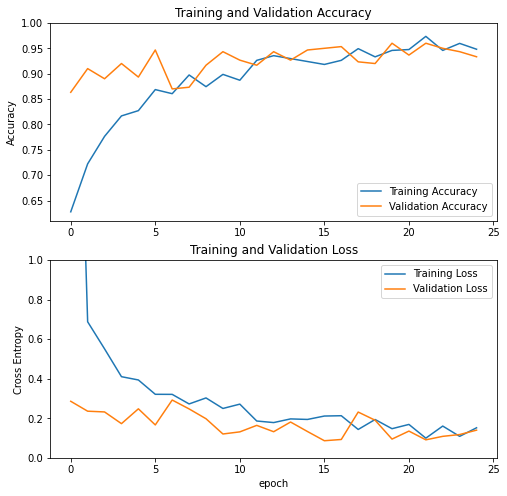

In [23]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Training with fine tuning

The second step of training process is the moment of the fine tuning. We unfreeze a certain number of layers and, the weights from these unfreeze layers will be tweaked with the head of the model. In this case, we unfreeze the last convolutional block.

To avoid over-fit, we consider a step function to drop down slightly the learning rate every $10$ epochs. In addition, we change the regularization into SGD with initial learn rate of $0.001$. The total of epochs is $50$.

In [24]:
for layer in baseModel.layers[15:]:
    layer.trainable = True #unfreezing

In [25]:
callbacks = [LearningRateScheduler(LRFunc.step_decay)] #defining the step function decay

In [26]:
opt = SGD()
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"]) #compiling the model

In [27]:
H_fine = model.fit(aug.flow(X_train, y_train, batch_size=32), 
                             validation_data=(X_val, y_val), epochs=50,
                             callbacks=callbacks,
                             steps_per_epoch=len(X_train) // 32, verbose=1)

  ...
    to  
  ['...']
Train for 28 steps, validate on 300 samples
The intitial learning rate is 0.001000
Epoch 1/50
28/28 [==============================] - 10s 353ms/step - loss: 0.0868 - accuracy: 0.9712 - val_loss: 0.0686 - val_accuracy: 0.9667
Epoch 2/50
28/28 [==============================] - 9s 319ms/step - loss: 0.0599 - accuracy: 0.9747 - val_loss: 0.0660 - val_accuracy: 0.9700
Epoch 3/50
28/28 [==============================] - 9s 319ms/step - loss: 0.0412 - accuracy: 0.9862 - val_loss: 0.0611 - val_accuracy: 0.9767
Epoch 4/50
28/28 [==============================] - 9s 319ms/step - loss: 0.0530 - accuracy: 0.9827 - val_loss: 0.0717 - val_accuracy: 0.9633
Epoch 5/50
28/28 [==============================] - 9s 318ms/step - loss: 0.0351 - accuracy: 0.9885 - val_loss: 0.0635 - val_accuracy: 0.9800
Epoch 6/50
28/28 [==============================] - 9s 323ms/step - loss: 0.0292 - accuracy: 0.9885 - val_loss: 0.0600 - val_accuracy: 0.9800
Epoch 7/50
28/28 [=====================

## Visualizing the results on the test set after fine tuning

In [28]:
predictions = model.predict(X_val, batch_size=32)
predictions = tf.where(predictions < 0.5, 0, 1)
print(classification_report(y_val,
                            predictions,
                            target_names=classNames))

              precision    recall  f1-score   support

          OM       0.99      0.99      0.99       152
         PSG       0.99      0.99      0.99       148

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, predictions)
print(cm)

[[150   2]
 [  1 147]]


In [30]:
acc += H_fine.history['accuracy']
val_acc += H_fine.history['val_accuracy']

loss += H_fine.history['loss']
val_loss += H_fine.history['val_loss']

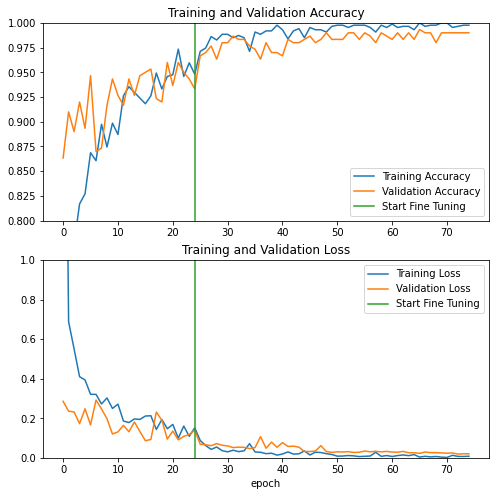

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([25-1,25-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([25-1,25-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig("results.jpg")
plt.show()


## Visualizing the results on the test set

To test the model, we consider a sample of $10$ images, $5$ for each class.

In [32]:
dataset = "/home/igor/Documents/Artificial_Inteligence/Projects/OMXPSG/OMxPSG_CNN/test" # the path for the dataset

In [33]:
imagesPath = list(paths.list_images(dataset))

In [34]:
(test, lab_test) = dl.load(imagesPath, verbose=5)
test = test.astype("float") / 255.

[INFO] processed 5/10
[INFO] processed 10/10


In [35]:
lab_test = le.fit_transform(lab_test)

In [36]:
predictions = model.predict(test)
predictions = tf.where(predictions < 0.5, 0, 1)
print(classification_report(lab_test,
                            predictions,
                            target_names=classNames))

              precision    recall  f1-score   support

          OM       0.83      1.00      0.91         5
         PSG       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



In [37]:
preds = predictions.numpy()

In [38]:
list_pred = [0 if x < 0.5 else 1 for x in preds]

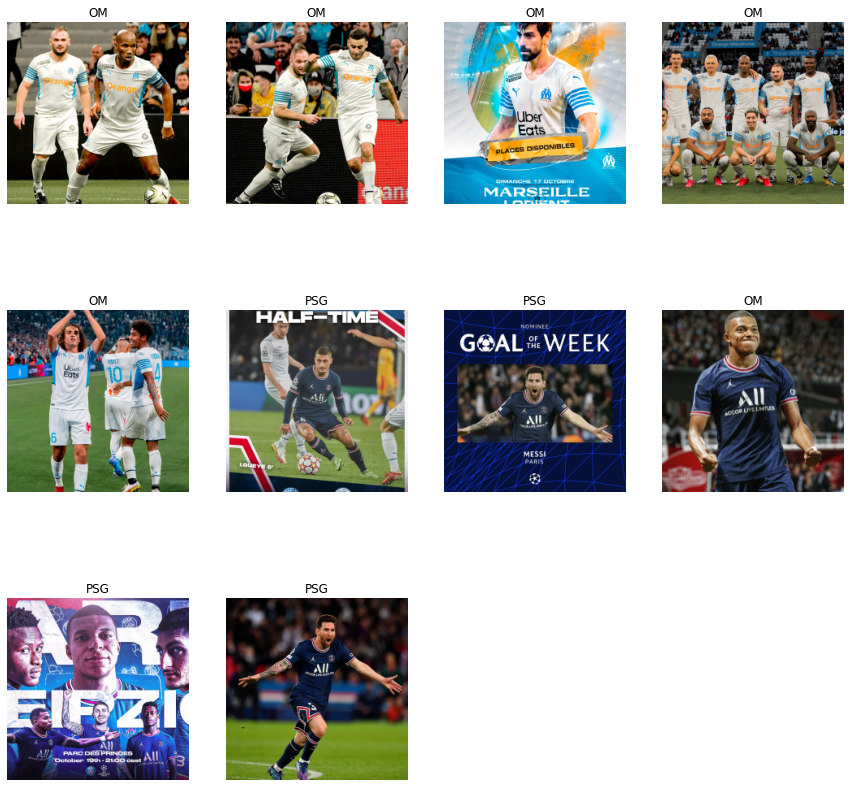

In [39]:
plt.figure(figsize=(15, 15))
for i in range(10):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(cv2.cvtColor(test[i].astype('float32'), cv2.COLOR_BGR2RGB))
    plt.title(classNames[list_pred[i]])
    plt.axis("off")

In [40]:
model.save('omxpsg.h5')

## Conclusions

The fine tuning technique is a good tool when we don’t have enough data. The results confirms it, the loss function curves for the training set and validation are nearly overlapped, that indicates there's no overfit. On the validation set the accuracy has a value of $99\%$, very good result and, on the test set $92\%$, but we’ve considered just $10$ images, the results remain accurate. The model is able to be used for the object detection task  with the composed model (Viola-Jones and CNN classification).